<a href="https://colab.research.google.com/github/vokulovskiy/Counting-people-at-the-gate/blob/main/%D0%9F%D0%BE%D0%B4%D0%B3%D0%BE%D1%82%D0%BE%D0%B2%D0%BA%D0%B0_%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D0%B0_%D0%B4%D0%BB%D1%8F_%D0%B4%D0%BE%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Подсчет количества рабочих на стройке
#Задача: дообучить нейросеть данными с видеокамеры
#создаем датасет с помощью предобученной модели
%pip install ultralytics
import cv2
from ultralytics import YOLO
# Для работы с файлами
import os 
import shutil
model = YOLO('yolov8m.pt')
path='/content/runs/detect/predict/'
txt_path='/content/txt/'
img_path='/content/img/'
os.mkdir(txt_path)                 #при помощии команды "mkdir" создадим новую папку
os.mkdir(img_path)                 #при помощии команды "mkdir" создадим новую папку
## Подключение гугл диска для сохранения модели
## с гугл диска быстро работает, и не нужно каждый раз копировать файл на колаб машину
from google.colab import drive
drive.mount('/content/gdrive')



In [ ]:
#os.remove(path+'labels/image0.txt') 
# Загрузка видеофайла
cap = cv2.VideoCapture('/content/gdrive/MyDrive/models/camera3_01.mp4')
kadr=0
kadrold=-5
while 30:
    # Чтение кадра из видео
    ret, frame = cap.read()
    if not ret:
        break
    kadr+=1
    if kadr-kadrold>5:
        print('Кадр:',kadr)
        if os.path.isfile(path+'labels/image0.txt'):
            os.remove(path + 'labels/image0.txt')
        pred=model.predict(source=frame, save=False, save_txt=True, classes=0)  # save predictions as labels ,name='predict'
        if len(pred[0])>2: # берем кадры где больше 2 человек и подряд берем только 1 из 5 кадров
            kadrold=kadr
            # Сохранение кадра как изображения
            cv2.imwrite(img_path+'image'+str(1000+kadr)+'.jpg', frame)
            # Сохранение рамок
            if os.path.exists(path+'labels/image0.txt'):
                os.rename(path+'labels/image0.txt', txt_path+'image'+str(1000+kadr)+'.txt') 


In [ ]:
#Сжимаем файлы
import pathlib
import zipfile

directory = pathlib.Path(img_path)

with zipfile.ZipFile("/content/img.zip", mode="w") as archive:
   for file_path in directory.iterdir():
       archive.write(file_path, arcname=file_path.name)

directory = pathlib.Path(txt_path)

with zipfile.ZipFile("/content/txt.zip", mode="w") as archive:
   for file_path in directory.iterdir():
       archive.write(file_path, arcname=file_path.name)



In [ ]:
# Копируем на свой гугл диск
shutil.copyfile("/content/img.zip", "/content/gdrive/MyDrive/models/img.zip")
shutil.copyfile("/content/txt.zip", "/content/gdrive/MyDrive/models/txt.zip")

'/content/gdrive/MyDrive/models/txt.zip'

Дальше отключаемся от колаба и работаем на своем компьютере локально.

Копируем из колаба файлы на локальный комп.

В моем примере я скопировал изображения в каталог c:\temp\img\, метки в каталог c:\temp\txt\

Для поготовки датасета я выбрал программу 'VGG image annotator' https://www.robots.ox.ac.uk/~vgg/software/via/.  

Скачать можно здесь https://www.robots.ox.ac.uk/~vgg/software/via/downloads/via-2.0.12.zip (~400KB)

# **Обзор**
VGG Image Annotator — это простое и автономное программное обеспечение для ручной аннотации изображений, аудио и видео. VIA работает в веб-браузере и не требует установки или настройки. Полное программное обеспечение VIA умещается на одной автономной HTML-странице размером менее 400 килобайт, которая запускается как автономное приложение в большинстве современных веб-браузеров.

VIA — это проект с открытым исходным кодом , основанный исключительно на HTML, Javascript и CSS (без зависимости от внешних библиотек). VIA разработан в Visual Geometry Group (VGG) и выпущен под лицензией BSD-2 , что позволяет использовать его как для академических проектов, так и для коммерческих приложений.



В этой программе свой формат хранения меток, поэтому нужен декодер.


Код, который ниже нужно выполнить на локальном питоне не на колабе.



In [ ]:
#YOLO to CSV for VGG image annotator
import os
import cv2
txt_dir = "C:/Temp/txt/"
img_dir = "C:/Temp/img/"
spf = os.listdir(txt_dir)
spi = os.listdir(img_dir)
src = cv2.imread(img_dir+spi[0], cv2.IMREAD_UNCHANGED)
width = src.shape[1]
height = src.shape[0]
my_file = open(img_dir + "labels.csv", "w+")
my_file.write('filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes\n')
for patch in spf:
    if patch.split('.')[1] == 'txt':
        stats = os.stat(img_dir + patch.split('.')[0] + '.jpg')
        size = stats.st_size
        with open(txt_dir + patch) as file:
            sss = file.readlines()
            sss = [x for x in sss if x]
            for i, s in enumerate(sss):
                cls = s.split()[0]
                coord = [float(i) for i in s.split()[1:]]
                #YOLO, метки находятся в текстовых файлах с нормализованными xmax, ymax, width, height
                #VIA: xcenter, ycenter, width, height
                x = coord[0] * width
                y = coord[1] * height
                w = coord[2] * width
                h = coord[3] * height
                coord[0] = x - w / 2
                coord[1] = y - h / 2
                coord[2] = w
                coord[3] = h
                coord = [str(int(i)) for i in coord]
                st = patch.split('.')[0] + '.jpg,' + str(size) + ',"{}",' + str(len(sss)) + ',' + str(i) + \
                     ',"{""name"":""rect"",""x"":' + coord[0] + ',""y"":' + coord[1] + ',""width"":' + coord[2] + \
                     ',""height"":' + coord[3] + '}","{""'+cls+'"":""'+cls+'""}"'
                my_file.write(st + '\n')
                print(st)
my_file.close()


'/content/gdrive/MyDrive/models/txt.zip'

В результате выполнения программы должен получиться файл C:\Temp\img\labels.csv
   

*   Качаем VGG Image Annotator, распаковываем его в каталог на локальной машине(у меня C:\Temp\via-2.0.12\). Запускаем via.html
*   Project -> Add local files -> выбираем все наши изображения и нажимаем "открыть"
*   Annotation -> Import Annotations (from csv) -> выбираем наш файл C:\Temp\img\labels.csv


Сейчас мы видим все предсказанные рамки на наших изображениях.

*   Пробегаем по кадрам, удаляем лишние, добавляем не достающие, изменяем не правильные.

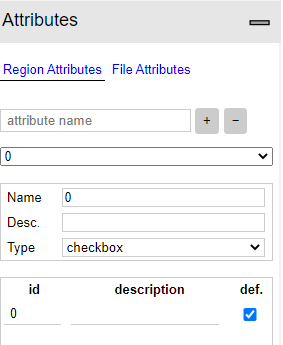

Атрибуты нужно настроить как на картинке, иначе потом проблемы будут. Проверить можно Annotation -> Preview Annotations
*   Сохраняем обязательно проект
*   Annotation -> Export Annotations (as csv). копируем полученный файл в C:\Temp\img\via_project.csv
*   Делаем обратное действие: кодируем датасет в формат YOLO. Так же выполняем на локальной машине









In [ ]:
# CSV from 'VGG image annotator' to YOLO
import os, cv2, shutil
from random import shuffle

shake = True  # Нужно ли перемешивать выборки
proc_valid = 20  # процент проверочной выборки
zip_file = "C:/Temp/dataset.zip"
proj_dir = "C:/Temp/yolo/"
img_dir = "C:/Temp/img/"
spi = os.listdir(img_dir)
sp = []
for s in spi:  # оставляем только имя файла без расширения
    if s.split('.')[1] == 'jpg':
        sp.append(s.split('.')[0])
if not os.path.exists(proj_dir): os.mkdir(proj_dir)
if not os.path.exists(proj_dir + 'txt/'): os.mkdir(proj_dir + 'txt/')
src = cv2.imread(img_dir + sp[0] + '.jpg', cv2.IMREAD_UNCHANGED)  # считываем параметры картинки
width = src.shape[1]
height = src.shape[0]
label_f = ''
with open(img_dir + "via_project.csv", "r") as f:
    line = f.readline()  # Первая строка не нужна
    l = open(img_dir + sp[0] + '.jpg', "r")  # открываем любой файл
    while True:
        # считываем строку
        line = f.readline()
        # прерываем цикл, если строка пустая
        if not line:
            break
        line = line.split(',')
        name_f = line[0].split('.')[0]  # имя файла без расширения
        if len(line) == 11 and name_f in sp:  # отсекаем не правильные рамки и удаленные файлы
            if len(line[10].split('"')) < 4:  # Если вдруг класс не поставлен, ставим 0
                cls = '0'
            else:
                cls = line[10].split('"')[3]
            if label_f != name_f:
                if not l.closed: l.close()
                label_f = name_f
                l = open(proj_dir + 'txt/' + name_f + '.txt', "w+")
            # VIA: xcenter, ycenter, width, height
            # YOLO, метки находятся в текстовых файлах с нормализованными xmax, ymax, width, height
            x = int(line[6].split(':')[1])
            y = int(line[7].split(':')[1])
            w = int(line[8].split(':')[1])
            h = int(line[9].split(':')[1].split('}')[0])
            x = str((x + w / 2) / width)
            y = str((y + h / 2) / height)
            w = str(w / width)
            h = str(h / height)
            st = cls + ' ' + x + ' ' + y + ' ' + w + ' ' + h
            l.write(st + '\n')
            print(label_f, st)
    if not l.closed: l.close()

# Перемешиваем и делим на тренировочную и проверочную выборки
if shake: shuffle(sp)
# Готовим структуру каталогов
shutil.rmtree(proj_dir + 'train/', ignore_errors=True)
shutil.rmtree(proj_dir + 'valid/', ignore_errors=True)
if not os.path.exists(proj_dir + 'train/'): os.mkdir(proj_dir + 'train/')
if not os.path.exists(proj_dir + 'valid/'): os.mkdir(proj_dir + 'valid/')
if not os.path.exists(proj_dir + 'train/images/'): os.mkdir(proj_dir + 'train/images/')
if not os.path.exists(proj_dir + 'train/labels/'): os.mkdir(proj_dir + 'train/labels/')
if not os.path.exists(proj_dir + 'valid/images/'): os.mkdir(proj_dir + 'valid/images/')
if not os.path.exists(proj_dir + 'valid/labels/'): os.mkdir(proj_dir + 'valid/labels/')
# Перемещаем файлы по каталогам
for n in sp[:len(sp) * proc_valid // 100]:  # проверочная выборка
    shutil.move(proj_dir + 'txt/' + n + '.txt', proj_dir + 'valid/labels/')
    shutil.copy(img_dir + n + '.jpg', proj_dir + 'valid/images/')
for n in sp[len(sp) * proc_valid // 100:]:  # тестовая выборка
    shutil.move(proj_dir + 'txt/' + n + '.txt', proj_dir + 'train/labels/')
    shutil.copy(img_dir + n + '.jpg', proj_dir + 'train/images/')
shutil.rmtree(proj_dir + 'txt/', ignore_errors=True)
print('Тренировочная выборка:', len(sp[len(sp) * proc_valid // 100:]), '  Проверочная выборка:',
      len(sp[:len(sp) * proc_valid // 100]))

# создаем файл .yaml
s = """

        train: ../train/images
        val: ../valid/images
        test: 

        # number of classes
        nc: 1

        # class names
        names: ['person']
"""
with open(proj_dir + "data.yaml", "w+") as f:
    f.write(s)

# Сжимаем файлы
import pathlib
from zipfile import ZipFile

directory = pathlib.Path(proj_dir)

with ZipFile(zip_file, "w") as archive:
    for file_path in directory.rglob("*"):
        archive.write(file_path, arcname=file_path.relative_to(directory))

shutil.rmtree(proj_dir, ignore_errors=True) # Стираем лишние файлы, но только если zip файл поместили не туда же

stats = os.stat(zip_file)
print(f'Размер архива с датасетом: {stats.st_size} bytes ({zip_file})')


Получился ахив dataset.zip, копируем его на свой гугл диск (я копирую в каталог models).

Далее работаем в колабе.

In [1]:
%pip install ultralytics
## Подключение гугл диска 
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
import os
TRAIN_DIR = '/content/my_yolo/'   #полный путь к папке сохраним в переменной TRAIN_DIR
os.mkdir(TRAIN_DIR)                 #при помощии команды "mkdir" создадим новую папку
!unzip -q -o /content/gdrive/MyDrive/models/dataset.zip  -d {TRAIN_DIR} 

ключ -q минимизирует информационные сообщения распаковщика

ключ -o включает режим перезаписи, на случай, если по путям распаковки существуют другие файлы

ключ -d после пробела указывается каталог, в который нужно распаковать архив

вы можете самостоятельно поэкспериментировать с ключами unzip. Чтобы посмотреть справку по другим опциям программы можно запустить ее с ключом --h


#Обучение модели

Вот пояснения ко всем аргументам , которые мы используем:

task: Хотим ли мы detect, segment или classify на выбранном нами наборе данных.

mode: Режим может быть либо train, val или predict. Поскольку мы проводим обучение, оно должно быть train.

model: Модель, которую мы хотим использовать. Здесь мы используем модель YOLOv8 Nano, предварительно обученную на наборе данных COCO.

imgsz: Размер изображения. Разрешение по умолчанию - 640.

data: Путь к файлу YAML dataset.

epochs: Количество эпох, для которых мы хотим обучаться.

batch: Размер пакета для загрузчика данных. Вы можете увеличить или уменьшить его в зависимости от доступности памяти вашего графического процессора.

name: Имя каталога результатов для runs/detect.

In [4]:
#Обучение модели
from ultralytics import YOLO
 
# Load the model.
model = YOLO('yolov8n.pt')
 
# Training.
results = model.train(
   data='/content/my_yolo/data.yaml',
   imgsz=640,
   epochs=10,
   batch=8,
   name='yolov8n_custom')

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.58 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/my_yolo/data.yaml, epochs=10, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dyn

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

In [9]:
#Оценка обучения
model.val()

Ultralytics YOLOv8.0.58 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/my_yolo/valid/labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                   all         59        217      0.876      0.814       0.91      0.743
Speed: 3.6ms preprocess, 13.2ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs/detect/yolov8n_custom2


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f63eefcef70>
fitness: 0.7599545081219266
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.74327])
names: {0: 'person'}
plot: True
results_dict: {'metrics/precision(B)': 0.8760690041231302, 'metrics/recall(B)': 0.8144062129783098, 'metrics/mAP50(B)': 0.9101122363792373, 'metrics/mAP50-95(B)': 0.7432703160933364, 'fitness': 0.7599545081219266}
save_dir: PosixPath('runs/detect/yolov8n_custom2')
speed: {'preprocess': 3.5849991491285422, 'inference': 13.248447644508492, 'loss': 0.0025134975627317266, 'postprocess': 6.329152543665999}

In [7]:
#Сохраняем лучшую модель на гугл диск, дальше используем ее для детекции
import shutil
shutil.copyfile("runs/detect/yolov8n_custom/weights/best.pt", "/content/gdrive/MyDrive/models/yolov8n_mod.pt")

None
